In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd '/content/drive/My Drive/Kvantitativ biologi og sygdomsmodellering/Bachelor project'

/content/drive/My Drive/Kvantitativ biologi og sygdomsmodellering/Bachelor project


In [0]:
cd '/content/drive/My Drive/DTU/Bachelor/Data'

/content/drive/My Drive/DTU/Bachelor/Data


In [0]:
# Loading packages
#-------------------------------------------------------------------------------
import os
import numpy as np
import pandas as pd
import cv2
import time
import copy
import itertools

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve
from PIL import Image
from sklearn.metrics import brier_score_loss

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import DataLoader,Dataset
from torch.optim import lr_scheduler
from torch.autograd import Variable

import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
from torchvision.transforms import Normalize,CenterCrop,Resize,Compose, ToPILImage

In [0]:
train_path='train/'
valid_path='valid/'

#Load data: 
train_img_path=pd.read_csv('MURA-v1.1/train_image_paths.csv')
valid_img_path=pd.read_csv('MURA-v1.1/valid_image_paths.csv')
train_labels=pd.read_csv('MURA-v1.1/train_labeled_studies.csv')
valid_labels=pd.read_csv('MURA-v1.1/valid_labeled_studies.csv')

#Label anomaly
train_img_path['Label']=train_img_path.Img_Path.apply(lambda x:1 if 'positive' in x else 0)
valid_img_path['Label']=valid_img_path.Img_Path.apply(lambda x:1 if 'positive' in x else 0)

#Label one-hot-encode for anatomy:
train_img_path['ELBOW']= train_img_path.Img_Path.apply(lambda x:1 if 'ELBOW' in x else 0)
train_img_path['SHOULDER']= train_img_path.Img_Path.apply(lambda x:1 if 'SHOULDER' in x else 0)
train_img_path['FINGER']= train_img_path.Img_Path.apply(lambda x:1 if 'FINGER' in x else 0)
train_img_path['FOREARM']= train_img_path.Img_Path.apply(lambda x:1 if 'FOREARM' in x else 0)
train_img_path['HAND']= train_img_path.Img_Path.apply(lambda x:1 if 'HAND' in x else 0)
train_img_path['HUMERUS']= train_img_path.Img_Path.apply(lambda x:1 if 'HUMERUS' in x else 0)
train_img_path['WRIST']= train_img_path.Img_Path.apply(lambda x:1 if 'WRIST' in x else 0)

valid_img_path['ELBOW']= valid_img_path.Img_Path.apply(lambda x:1 if 'ELBOW' in x else 0)
valid_img_path['SHOULDER']= valid_img_path.Img_Path.apply(lambda x:1 if 'SHOULDER' in x else 0)
valid_img_path['FINGER']= valid_img_path.Img_Path.apply(lambda x:1 if 'FINGER' in x else 0)
valid_img_path['FOREARM']= valid_img_path.Img_Path.apply(lambda x:1 if 'FOREARM' in x else 0)
valid_img_path['HAND']= valid_img_path.Img_Path.apply(lambda x:1 if 'HAND' in x else 0)
valid_img_path['HUMERUS']= valid_img_path.Img_Path.apply(lambda x:1 if 'HUMERUS' in x else 0)
valid_img_path['WRIST']= valid_img_path.Img_Path.apply(lambda x:1 if 'WRIST' in x else 0)

# RAW DATALOADER

In [0]:
####################################
class Mura(Dataset):
    def __init__(self,df,root,phase, transform=None):
        self.df=df
        # if phase == 'val':
        #  rndperm = np.random.permutation(len(self.df))[0:100]
        #  self.df = df.iloc[rndperm,:]

        self.root=root
        self.transform=transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        img_name=self.df.iloc[idx,0]
        #img=Image.open(img_name, mode = 'r')
        img = cv2.imread(img_name)
        
        label_anomaly= self.df.iloc[idx,1]
        label_anatomy = np.asarray(self.df.iloc[idx,2:], dtype = np.int16)
        
        if self.transform is not None:
            img=self.transform(img)
        
        # Transformerer image til ImageNet std og Mean 
        # https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation
        mean = torch.mean(img[0,:,:])
        sd = torch.std(img[0,:,:])
        img[0,:,:] = 0.485 + (img[0,:,:] - mean)*(0.229/sd)
        img[1,:,:] = 0.456 + (img[1,:,:] - mean)*(0.224/sd)
        img[2,:,:] = 0.406 + (img[2,:,:] - mean)*(0.225/sd)
        return img,label_anomaly, label_anatomy
	
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
	'train': transforms.Compose([
		transforms.ToPILImage(),
		#transforms.RandomResizedCrop(224),
		#transforms.RandomHorizontalFlip(),
		transforms.Resize((224,224)),
		transforms.ToTensor()
		#transforms.Normalize([0.236, 0.236, 0.236], [0.109, 0.109, 0.109])
	]),
	'val': transforms.Compose([
		transforms.ToPILImage(),
		transforms.Resize((224,224)),
		#transforms.CenterCrop(224),
		transforms.ToTensor()
		#transforms.Normalize([0.236, 0.236, 0.236], [0.109, 0.109, 0.109])
	]),
}

#Dataloader:
train_mura_dataset=Mura(df=train_img_path,root='./',phase = 'train', transform=data_transforms['train'])
val_mura_dataset=Mura(df=valid_img_path,root='./',phase = 'val',transform=data_transforms['val'])
train_loader=DataLoader(dataset=train_mura_dataset,batch_size=1,num_workers=0, shuffle = True )
val_loader=DataLoader(dataset=val_mura_dataset,batch_size=1,num_workers=0, shuffle = False )

dataloaders={
	'train':train_loader,
	'val':val_loader
}
dataset_sizes={
	'train':len(train_mura_dataset),
	'val':len(val_mura_dataset)
}



# ROI DATALOADER

In [0]:
class Mura(Dataset):
    def __init__(self,df,root,phase, transform=None):
        self.df=df
        # if phase=='train':
        #   rndperm = np.random.permutation(np.arange(0,len(self.df)))
        #   self.df = self.df.iloc[rndperm,:]
        # # if phase=='val':
        #   rndperm = np.random.permutation(np.arange(0,len(self.df)))
        #   self.df = self.df.iloc[rndperm,:]
          
        self.root=root
        self.transform=transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        img_name=self.df.iloc[idx,0]
        path = img_name.split('image')[0]
        img = img_name.split('/')[-1].split(".")[0]
        img_name = os.path.join(path+img+'_roi.png')
        img = cv2.imread(img_name)
        
        label_anomaly= self.df.iloc[idx,1]
        label_anatomy = np.asarray(self.df.iloc[idx,2:], dtype = np.int16)
        
        if self.transform is not None:
            img=self.transform(img)
        
        # Transformerer image til ImageNet std og Mean 
        # https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation
        mean = torch.mean(img[0,:,:])
        sd = torch.std(img[0,:,:])
        img[0,:,:] = 0.485 + (img[0,:,:] - mean)*(0.229/sd)
        img[1,:,:] = 0.456 + (img[1,:,:] - mean)*(0.224/sd)
        img[2,:,:] = 0.406 + (img[2,:,:] - mean)*(0.225/sd)
        return img,label_anomaly, label_anatomy
    
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.Resize((224,224)),
        transforms.ToTensor()
        #transforms.Normalize([0.236, 0.236, 0.236], [0.109, 0.109, 0.109])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor()
        #transforms.Normalize([0.236, 0.236, 0.236], [0.109, 0.109, 0.109])
    ]),
}

#Dataloader:
train_mura_dataset=Mura(df=train_img_path,root='./',phase = 'train', transform=data_transforms['train'])
val_mura_dataset=Mura(df=valid_img_path,root='./',phase = 'val',transform=data_transforms['val'])
train_loader=DataLoader(dataset=train_mura_dataset,batch_size=1,num_workers=0, shuffle = True )
val_loader=DataLoader(dataset=val_mura_dataset,batch_size=1,num_workers=0, shuffle = True )

dataloaders={
    'train':train_loader,
    'val':val_loader
}
dataset_sizes={
    'train':len(train_mura_dataset),
    'val':len(val_mura_dataset)
}

In [0]:
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()

        densenet121 = models.densenet121(pretrained = True)
        modules=list(densenet121.children())[-2][:-1]

        # We encode the data onto the latent space using two linear layers
        self.encoder = nn.Sequential(*modules)


        # The latent code must be decoded into the original image
        self.anomaly = nn.Sequential(
            nn.Linear(in_features=50176, out_features=1)
            )
        self.sigmoid = nn.Sigmoid()
        ##
        ###Bruger nn.Logsoftmax --> nn.NLLoss i stedet for nn.Crossentropy (hvor softmax er indbygget), for at kunne give 
        ### probabilities til f1_score når denne skal beregnes. 
        ###
        self.Logsoft = nn.LogSoftmax(dim=1)
        self.softmax = nn.Softmax(dim=1)

        self.anatomy = nn.Sequential(
            nn.Linear(in_features = 50176, out_features = 7)
                )

    def forward(self, x): 
        outputs = {}
        x = self.encoder(x)

        x = x.view(x.shape[0],-1)

        x_anomaly = self.anomaly(x)
        x_anomaly = self.sigmoid(x_anomaly)

        x_anatomy = self.anatomy(x)
        x_anatomy = self.softmax(x_anatomy)

        outputs["anomaly"] = x_anomaly
        outputs["anatomy"] = x_anatomy

        return outputs


net = DenseNet()
# original saved file with DataParallel
state_dict  = torch.load("/content/drive/My Drive/Kvantitativ biologi og sygdomsmodellering/Bachelor project/Bachelor/saved_models/DenseNet_v2_ft/DenseNet_epoch_100.pt")
#state_dict = torch.load('../saved_models/DenseNet_e30/DenseNet_epoch_30.pt')
# create new OrderedDict that does not contain module.
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove module.
    new_state_dict[name] = v
# load params
net.load_state_dict(new_state_dict)
net.eval();

In [0]:
class ResNet(nn.Module):
	def __init__(self):
		super(ResNet, self).__init__()
		
		resnet152 = models.resnet152(pretrained = True)
		modules=list(resnet152.children())[:-2]

		# We encode the data onto the latent space using two linear layers
		self.encoder = nn.Sequential(*modules)


		# The latent code must be decoded into the original image
		self.anomaly = nn.Sequential(
			nn.Linear(in_features=100352, out_features=1)
			)
		self.sigmoid = nn.Sigmoid()
		##
		###Bruger nn.Logsoftmax --> nn.NLLoss i stedet for nn.Crossentropy (hvor softmax er indbygget), for at kunne give 
		### probabilities til f1_score når denne skal beregnes. 
		###
		self.Logsoft = nn.LogSoftmax(dim=1)

		self.softmax = nn.Softmax(dim=1)

		self.anatomy = nn.Sequential(
			nn.Linear(in_features = 100352, out_features = 7)
				)

	def forward(self, x): 
		outputs = {}
		x = self.encoder(x)
		
		x = x.view(x.shape[0],-1)
		
		x_anomaly = self.anomaly(x)
		x_anomaly = self.sigmoid(x_anomaly)

		x_anatomy = self.anatomy(x)
		x_anatomy = self.softmax(x_anatomy)

		outputs["anomaly"] = x_anomaly
		outputs["anatomy"] = x_anatomy
		
		return outputs

net2 = ResNet()
# original saved file with DataParallel
state_dict  = torch.load('/content/drive/My Drive/Kvantitativ biologi og sygdomsmodellering/Bachelor project/Bachelor/saved_models/ResNet_roi_e30/ResNet_epoch_30.pt')
#state_dict = torch.load('../saved_models/DenseNet_e30/DenseNet_epoch_30.pt')
# create new OrderedDict that does not contain module.
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove module.
    new_state_dict[name] = v
# load params
net2.load_state_dict(new_state_dict)
net2.eval();

In [0]:
y_anomaly = []
prob_anomaly = []

y_elbow = []
prob_elbow = []

y_shoulder = []
prob_shoulder = []

y_finger = []
prob_finger = []

y_forearm = []
prob_forearm = []

y_hand = []
prob_hand = []

y_humerus = []
prob_humerus = []

y_wrist = []
prob_wrist = []

i = 0

for inputs, labels_anomaly, labels_anatomy in dataloaders['val']:
  with torch.set_grad_enabled(False):
    outputs = net(inputs)

    labels_anomaly = labels_anomaly.detach().numpy()
    y_anomaly.append(labels_anomaly)
    prob_anomaly.append(outputs['anomaly'].detach().numpy()[0].item())

    labels_anatomy = labels_anatomy.detach().numpy()
    prob_anatomy = outputs['anatomy'].detach().numpy()
    
    # 0 = Elbow
    #if labels_anatomy == 0:
    y_elbow.append(labels_anatomy[0,0])
    prob_elbow.append(prob_anatomy[0,0])
    #else:
    #  y_elbow.append(np.array(0))
    #  prob_elbow.append(1-prob_anatomy[0,0])

    # 1 = Shoulder
    #if labels_anatomy == 1:
    y_shoulder.append(labels_anatomy[0,1])
    prob_shoulder.append(prob_anatomy[0,1])
    #else:
    #   y_shoulder.append(np.array(0))
    #   prob_shoulder.append(1-prob_anatomy[0,1])

    # # 2 = Finger
    # if labels_anatomy == 2:
    y_finger.append(labels_anatomy[0,2])
    prob_finger.append(prob_anatomy[0,2])
    # else:
    #   y_finger.append(np.array(0))
    #   prob_finger.append(1-prob_anatomy[0,2])

    # # 3 = Forearm
    # if labels_anatomy == 3:
    y_forearm.append(labels_anatomy[0,3])
    prob_forearm.append(prob_anatomy[0,3])
    # else:
    #   y_forearm.append(np.array(0))
    #   prob_forearm.append(1-prob_anatomy[0,3])

    # # 4 = Hand
    # if labels_anatomy == 4:
    y_hand.append(labels_anatomy[0,4])
    prob_hand.append(prob_anatomy[0,4])
    # else:
    #   y_hand.append(np.array(0))
    #   prob_hand.append(1-prob_anatomy[0,4])

    # # 5 = Humerus
    # if labels_anatomy == 5:
    y_humerus.append(labels_anatomy[0,5])
    prob_humerus.append(prob_anatomy[0,5])
    # else:
    #   y_humerus.append(np.array(0))
    #   prob_humerus.append(1-prob_anatomy[0,5])

    # # 6 = Wrist
    # if labels_anatomy == 6:
    y_wrist.append(labels_anatomy[0,6])
    prob_wrist.append(prob_anatomy[0,6])
    # else:
    #   y_wrist.append(np.array(0))
    #   prob_wrist.append(1-prob_anatomy[0,6])





    if i % 100 == 0:
      print(i)
    i += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100


In [0]:
os.chdir('/content/drive/My Drive/Kvantitativ biologi og sygdomsmodellering/Bachelor project/Bachelor/Results/DenseNet_v2_ft')

with open('cc_anomaly.txt', 'w') as f:
  for item in y_anomaly:
    f.write("%s\n" % item)

  for item in prob_anomaly:
    f.write("%s\n" % item)

with open('cc_elbow.txt', 'w') as f:
  for item in y_elbow:
    f.write("%s\n" % item)

  for item in prob_elbow:
    f.write("%s\n" % item)

with open('cc_shoulder.txt', 'w') as f:
  for item in y_shoulder:
    f.write("%s\n" % item)

  for item in prob_shoulder:
    f.write("%s\n" % item)

with open('cc_finger.txt', 'w') as f:
  for item in y_finger:
    f.write("%s\n" % item)

  for item in prob_finger:
    f.write("%s\n" % item)

with open('cc_forearm.txt', 'w') as f:
  for item in y_forearm:
    f.write("%s\n" % item)

  for item in prob_forearm:
    f.write("%s\n" % item)

with open('cc_hand.txt', 'w') as f:
  for item in y_hand:
    f.write("%s\n" % item)

  for item in prob_hand:
    f.write("%s\n" % item)

with open('cc_humerus.txt', 'w') as f:
  for item in y_humerus:
    f.write("%s\n" % item)

  for item in prob_humerus:
    f.write("%s\n" % item)

with open('cc_wrist.txt', 'w') as f:
  for item in y_wrist:
    f.write("%s\n" % item)

  for item in prob_wrist:
    f.write("%s\n" % item)


In [0]:
###Load data ind: 
#Vælg hvilken mappe:
%cd '/content/drive/My Drive/Kvantitativ biologi og sygdomsmodellering/Bachelor project/Bachelor/Results/DenseNet_v2_ft_roi'

#-------------------------------------------------------------------------------
with open('cc_anomaly.txt', 'r') as f:
    x = f.read().splitlines()
prob_anomaly = np.asarray(x[3197:]).astype(float)
y_anomaly = np.zeros(3197)
i = 0
for item in x[:3197]:
  y_anomaly[i] = np.asarray(item.split('[')[1].split(']')[0])
  i += 1
#-------------------------------------------------------------------------------

###Anatomy:
with open('cc_elbow.txt', 'r') as f:
    x = f.read().splitlines()
lenx = int(len(x)/2)
prob_elbow = np.asarray(x[lenx:]).astype(float)
y_elbow = np.asarray(x[:lenx]).astype(int)

#-------------------------------------------------------------------------------
with open('cc_finger.txt', 'r') as f:
    x = f.read().splitlines()
lenx = int(len(x)/2)
prob_finger = np.asarray(x[lenx:]).astype(float)
y_finger = np.asarray(x[:lenx]).astype(int)

#-------------------------------------------------------------------------------
with open('cc_forearm.txt', 'r') as f:
    x = f.read().splitlines()
lenx = int(len(x)/2)
prob_forearm = np.asarray(x[lenx:]).astype(float)
y_forearm = np.asarray(x[:lenx]).astype(int)
#-------------------------------------------------------------------------------
with open('cc_hand.txt', 'r') as f:
    x = f.read().splitlines()
lenx = int(len(x)/2)
prob_hand = np.asarray(x[lenx:]).astype(float)
y_hand = np.asarray(x[:lenx]).astype(int)
#-------------------------------------------------------------------------------
with open('cc_humerus.txt', 'r') as f:
    x = f.read().splitlines()
lenx = int(len(x)/2)
prob_humerus = np.asarray(x[lenx:]).astype(float)
y_humerus = np.asarray(x[:lenx]).astype(int)
#-------------------------------------------------------------------------------
with open('cc_shoulder.txt', 'r') as f:
    x = f.read().splitlines()
lenx = int(len(x)/2)
prob_shoulder = np.asarray(x[lenx:]).astype(float)
y_shoulder = np.asarray(x[:lenx]).astype(int)
#-------------------------------------------------------------------------------
with open('cc_wrist.txt', 'r') as f:
    x = f.read().splitlines()
lenx = int(len(x)/2)
prob_wrist = np.asarray(x[lenx:]).astype(float)
y_wrist = np.asarray(x[:lenx]).astype(int)
#-------------------------------------------------------------------------------




/content/drive/.shortcut-targets-by-id/15nbpecT4fnrN6dwd8gZbs3zXmeT4FZJb/Bachelor/Results/DenseNet_v2_ft_roi


array([0.00094943, 0.00283974, 0.07252377, ..., 0.01262544, 0.01342415,
       0.01108124])

In [0]:
bins = 10
anomaly_y, anomaly_x = calibration_curve(y_anomaly,prob_anomaly, n_bins = bins)
elbow_y, elbow_x = calibration_curve(y_elbow, prob_elbow, n_bins = bins)
shoulder_y, shoulder_x = calibration_curve(y_shoulder, prob_shoulder, n_bins = bins)
finger_y, finger_x = calibration_curve(y_finger, prob_finger, n_bins = bins)
forearm_y, forearm_x = calibration_curve(y_forearm, prob_forearm, n_bins = bins)
hand_y, hand_x = calibration_curve(y_hand, prob_hand, n_bins = bins)
humerus_y, humerus_x = calibration_curve(y_humerus, prob_humerus, n_bins = bins)
wrist_y, wrist_x = calibration_curve(y_wrist, prob_wrist, n_bins =bins)


###Merge anatomy:
# anatomy_x = np.mean(np.vstack([elbow_x, shoulder_x, finger_x, forearm_x, hand_x, humerus_x, wrist_x]),axis= 0)
# anatomy_y = np.mean(np.vstack([elbow_y, shoulder_y, finger_y, forearm_y, hand_y, humerus_y, wrist_y]),axis = 0)

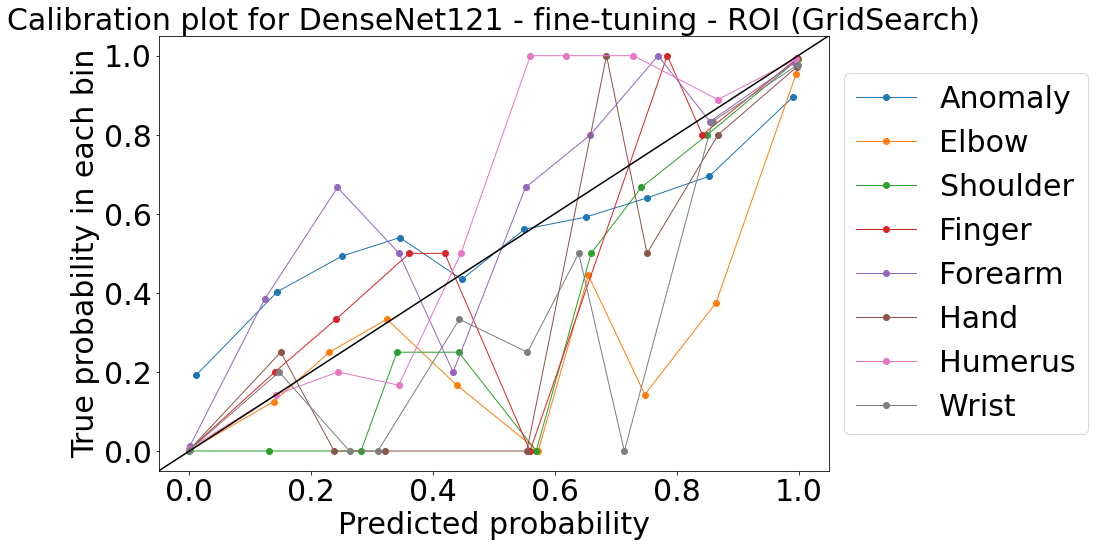

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(12,8))
# only these two lines are calibration curves
plt.plot(anomaly_x,anomaly_y , marker='o', linewidth=1, label='Anomaly')
plt.plot(elbow_x,elbow_y, marker = 'o', linewidth =1, label = 'Elbow')
plt.plot(shoulder_x,shoulder_y, marker = 'o', linewidth =1, label = 'Shoulder')
plt.plot(finger_x,finger_y, marker = 'o', linewidth =1, label = 'Finger')
plt.plot(forearm_x,forearm_y, marker = 'o', linewidth =1, label = 'Forearm')
plt.plot(hand_x,hand_y, marker = 'o', linewidth =1, label = 'Hand')
plt.plot(humerus_x,humerus_y, marker = 'o', linewidth =1, label = 'Humerus')
plt.plot(wrist_x,wrist_y, marker = 'o', linewidth =1, label = 'Wrist')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.title('Calibration plot for DenseNet121 - fine-tuning - ROI (GridSearch)', fontsize= 30)
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(loc = 'best')
plt.show()

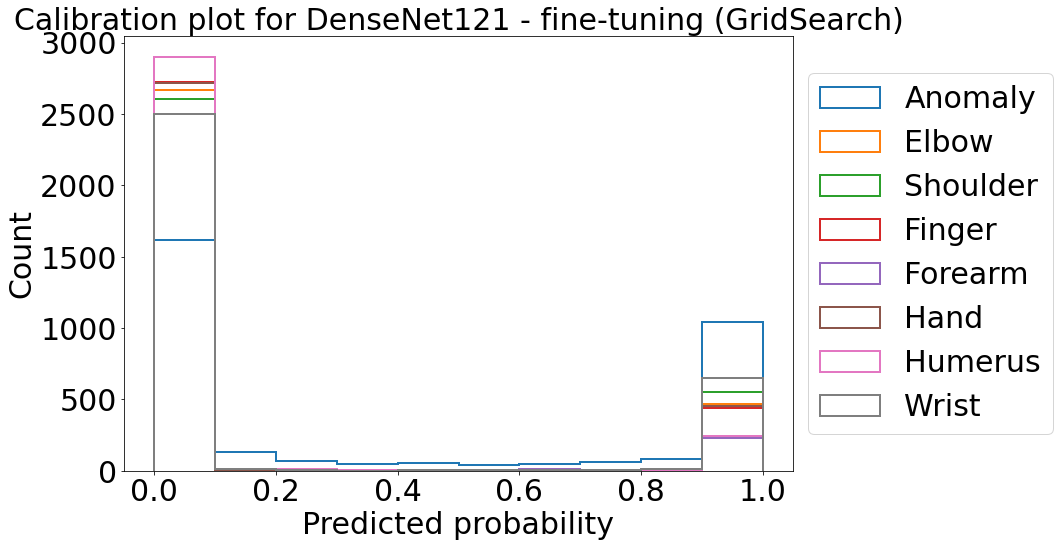

In [0]:
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(12,8))

plt.hist(prob_anomaly, range=(0, 1), bins=10,label = 'Anomaly',
                 histtype="step", lw=2,);
plt.hist(prob_elbow, range=(0, 1), bins=10, label ='Elbow' ,
                 histtype="step", lw=2);
plt.hist(prob_shoulder, range=(0, 1), bins=10,label = 'Shoulder',
                 histtype="step", lw=2);
plt.hist(prob_finger, range=(0, 1), bins=10,label = 'Finger',
                 histtype="step", lw=2);
plt.hist(prob_forearm, range=(0, 1), bins=10,label = 'Forearm',
                 histtype="step", lw=2);
plt.hist(prob_hand, range=(0, 1), bins=10,label = 'Hand',
                 histtype="step", lw=2);
plt.hist(prob_humerus, range=(0, 1), bins=10,label= 'Humerus',
                 histtype="step", lw=2);
plt.hist(prob_wrist, range=(0, 1), bins=10,label = 'Wrist',
                 histtype="step", lw=2);
plt.title('Calibration plot for DenseNet121 - fine-tuning (GridSearch)', fontsize = 30)

ax.set_xlabel('Predicted probability')
ax.set_ylabel('Count')


#plt.legend(loc = 'best')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [0]:
print('Brier scores \n')
print('anomaly:',brier_score_loss(y_anomaly, prob_anomaly))
print('elbow:',brier_score_loss(y_elbow, prob_elbow))
print('shoulder:',brier_score_loss(y_shoulder, prob_shoulder))
print('finger:',brier_score_loss(y_finger, prob_finger))
print('forearm:',brier_score_loss(y_forearm, prob_forearm))
print('hand:',brier_score_loss(y_hand, prob_hand))
print('humerus:',brier_score_loss(y_humerus, prob_humerus))
print('wrist:',brier_score_loss(y_wrist, prob_wrist))


Brier scores 

anomaly: 0.16668671016429368
elbow: 0.012892192391426534
shoulder: 0.005847353876439857
finger: 0.00839967005879145
forearm: 0.017852563502827067
hand: 0.010672195983399885
humerus: 0.008787636422309958
wrist: 0.012409405992261558


NameError: ignored

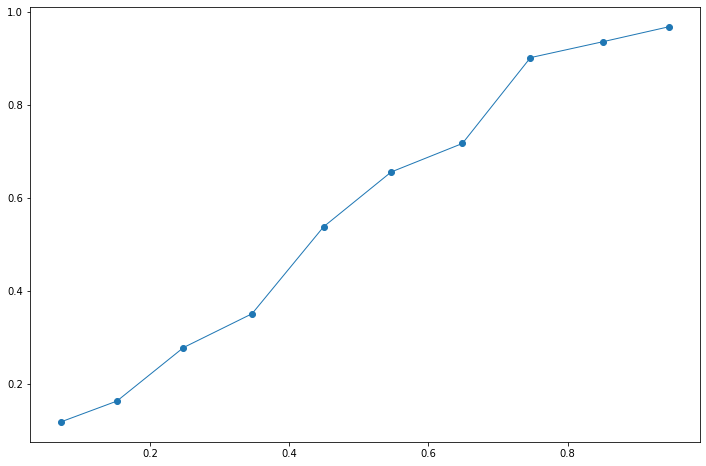

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots(figsize=(12,8))

# only these two lines are calibration curves
plt.plot(anomaly_x,anomaly_y , marker='o', linewidth=1, label='Anomaly')
plt.plot(anatomy_x,anatomy_y , marker='o', linewidth=1, label='Anatomy')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for DenseNet')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend(loc = 'best')
plt.show()

fig, ax = plt.subplots(figsize=(12,8))
plt.hist(prob_anomaly, range=(0, 1), bins=10,label = 'Anomaly',
                 histtype="step", lw=2);
plt.hist(prob_anatomy, range=(0, 1), bins=10,label = 'Anatomy',
                 histtype="step", lw=2);
fig.suptitle('Calibration plot for DenseNet ')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('Count')
plt.legend(loc = 'best')
plt.show()




In [0]:
outputs['anatomy'].detach().numpy()

array([[6.0137064e-04, 2.9952691e-05, 1.2048290e-04, 5.9709320e-05,
        4.7038284e-05, 8.6901364e-06, 9.9913281e-01]], dtype=float32)

In [0]:
data[2]

tensor([[0, 0, 0, 0, 0, 0, 1]], dtype=torch.int16)

In [0]:
from sklearn.calibration import CalibratedClassifierCV
?CalibratedClassifierCV.fit

In [0]:
cv = CalibratedClassifierCV(net, cv = 'prefit', method = 'sigmoid')

In [0]:
cv.fit(outputs['anatomy'].detach().numpy(), torch.max(data[2],1)[1])

RuntimeError: ignored

In [0]:
data[2].shape

torch.Size([1, 7])

In [0]:
?calibration_curve